## Model Pipeline CATS 12

### Lucas Jollie, Michelle Klein, Maaike Scholten, Folkert Stijnman

1. Extract features based on Chi Squared test and literature

(skip 2. and 3. if you just want the model) 

2. Validate Naive Bayes, Random Forest, MLP
3. Visualise in boxplot


4. Train model (parameters taken from validation)

In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

# 1 Load data and important genes

import pandas as pd

temp_list = []

with open("train_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_train = pd.DataFrame(temp_list[1:], columns=columns_temp)
X = df_train.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
X = X.transpose()

labels = []

with open("Train_clinical.txt", 'r') as temp_labels:
    next(temp_labels)
    for line in temp_labels:
        temp = line.strip()
        temp = temp.split()
        if temp[1].strip("\"") == "HER2+":
            labels.append(1)
        if temp[1].strip("\"") == "HR+":
            labels.append(2)
        if temp[1].strip("\"") == "Triple":
            labels.append(3)

Y = labels

# Find the important genes list here if needed (anyone at VU can view this link): https://docs.google.com/spreadsheets/d/18T0gJ6nX67aa7veYpRTn_0yymVCvFnnllGqiQyqsIcc/edit?usp=sharing
important_genes = [111, 157, 249, 65, 361, 360, 479, 576, 583, 688, 664, 625, 670, 772, 876, 877, 878, 937, 991, 992, 993, 966, 1136, 1137, 1092, 1207, 1234, 1370, 1371, 1387, 1296, 1310, 1583, 1407, 1575, 1513, 1589, 1611, 1697, 1645, 1657, 1725, 1734, 1735, 1865, 1904, 1911, 2017, 1965, 2015, 2016, 2207, 2074, 2075, 2306, 2184, 2135, 2136, 2200, 2201, 2071, 2160, 2161, 2446, 2681, 2682, 2683, 2684, 2685, 2732, 2744, 2794, 2822]
            
print(X)
print(Y)
print("The regions found in the literature were: ", important_genes)

          0    1    2    3    4    5    6    7    8    9     ... 2824 2825  \
Array.129    0    0    0    0    0    0    0    0    0    0  ...    2    2   
Array.34     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.67     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.24     0    0    0    0    0    0    0   -1    0    0  ...    0    0   
Array.22     0    0    0    0    0    0    0    0    0    0  ...    1    1   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Array.10     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.123    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.100    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.134   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...    1    1   
Array.130    0    0    0    0    0    0    0    0    0    0  ...    1    1   

          2826 2827 2828 2829 2830 2831 2832 2833  
Array.129  

In [13]:
## FEATURE SELECTION

#Loading data
patients = X.values.tolist()

# we need to shift the features by 1 since the chi2 function does not take non-negative values
patients_shift = []

for patient in patients:
    x = []
    for feature in patient:
        x.append(int(feature) + 1)
    patients_shift.append(x)

chi, p_val = chi2(patients_shift, Y)

imp_genes_p_values = []

for i, j in enumerate(important_genes):
    if p_val[j] >= 0.05:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "No"])
    else:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "Yes"])
    

important_genes_scores = pd.DataFrame(imp_genes_p_values, columns=["Gene", "Region number", "P-value", "Yes/No"])
pd.set_option('display.max_rows', 75)
print(important_genes_scores)

X_feature_selected = X

threshold = 0.05
for i, val in enumerate(p_val):
    if val >= threshold and i not in important_genes:
        X_feature_selected = X_feature_selected.drop([i], axis=1)
        
X = X_feature_selected
number_of_features = len(X.values.tolist()[0])
print("Number of features = {}".format(number_of_features))

                 Gene  Region number       P-value Yes/No
0              DIRAS3            111  6.897062e-01     No
1              PTPN22            157  7.287985e-01     No
2                 AGT            249  9.791761e-01     No
3               CLSPN             65  5.039604e-01     No
4   BARD1/CASP8/CTLA4            361  8.022867e-01     No
5               SF3B1            360  8.717109e-01     No
6              PIK3CA            479  4.007464e-01     No
7               NFKB1            576  8.076397e-01     No
8                FGF2            583  8.076397e-01     No
9               RAD50            688  1.138701e-01     No
10             MAP3K1            664  1.569463e-01     No
11               TERT            625  9.757757e-01     No
12             PIK3R1            670  4.250528e-02    Yes
13              CCND3            772  1.568220e-01     No
14               ESR1            876  4.297669e-01     No
15               ESR1            877  3.435048e-01     No
16            

In [9]:
# validation scheme

def nested_cross_validation(MODEL, PARAMS, X, Y, NUM_TRIALS):
    nested_scores = []
    
    for i in range(NUM_TRIALS):
        print("Running Trial {}...".format(i + 1))
        # K Fold inner & outer loop
        inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        
        # one vs. rest approach
        model_to_set = OneVsRestClassifier(MODEL)
        
        model = GridSearchCV(estimator=model_to_set, param_grid=PARAMS, cv=inner_cv, n_jobs=2)
        nested_score = cross_val_score(model, X=X, y=Y, cv=outer_cv)
        nested_scores.append([nested_score.mean(), nested_score.std()])
        print(nested_score.mean(), nested_score.std())
        
    return nested_scores

In [45]:
# Naive Bayes doesn't need parametrization

nb_nested = []

for i in range(100):
    cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    nb = OneVsRestClassifier(GaussianNB())
    nested_score = cross_val_score(nb, X=X, y=Y, cv=cv_folds)
    nb_nested.append([nested_score.mean(), nested_score.std()])
    
print(nb_nested)

[[0.8200000000000001, 0.08246211251235322], [0.82, 0.1341640786499874], [0.79, 0.0768114574786861], [0.78, 0.044721359549995794], [0.77, 0.15066519173319362], [0.8, 0.04898979485566356], [0.77, 0.08660254037844387], [0.84, 0.12328828005937952], [0.78, 0.060000000000000005], [0.78, 0.1], [0.8299999999999998, 0.08660254037844385], [0.8399999999999999, 0.08944271909999159], [0.8400000000000001, 0.09380831519646858], [0.8200000000000001, 0.11489125293076059], [0.77, 0.06557438524302002], [0.85, 0.06557438524301998], [0.81, 0.05916079783099616], [0.81, 0.0768114574786861], [0.81, 0.05916079783099617], [0.76, 0.1264911064067352], [0.84, 0.0632455532033676], [0.8200000000000001, 0.07211102550927981], [0.76, 0.0848528137423857], [0.8, 0.08485281374238568], [0.79, 0.01732050807568879], [0.77, 0.12124355652982143], [0.86, 0.06633249580710801], [0.81, 0.09110433579144302], [0.76, 0.11313708498984763], [0.8, 0.06928203230275512], [0.78, 0.12806248474865695], [0.77, 0.06557438524302002], [0.8, 0.03

In [47]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10, dtype=int)]
max_features = ['auto', 'sqrt']

parameters = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features}

rf = RandomForestClassifier()

rf_nested = nested_cross_validation(rf, parameters, X, Y, 100)

Running Trial 1...
0.7600000000000001 0.04898979485566356
Running Trial 2...
0.71 0.18841443681416772
Running Trial 3...
0.77 0.07141428428542847
Running Trial 4...
0.7200000000000001 0.0748331477354788
Running Trial 5...
0.74 0.1183215956619923
Running Trial 6...
0.8 0.06324555320336758
Running Trial 7...
0.75 0.09110433579144296
Running Trial 8...
0.7900000000000001 0.08660254037844387
Running Trial 9...
0.78 0.060000000000000005
Running Trial 10...
0.73 0.07141428428542851
Running Trial 11...
0.78 0.06
Running Trial 12...
0.77 0.07681145747868608
Running Trial 13...
0.75 0.08660254037844387
Running Trial 14...
0.8 0.16248076809271922
Running Trial 15...
0.76 0.07483314773547882
Running Trial 16...
0.77 0.08660254037844387
Running Trial 17...
0.7500000000000001 0.091104335791443
Running Trial 18...
0.78 0.060000000000000005
Running Trial 19...
0.76 0.15748015748023622
Running Trial 20...
0.73 0.08660254037844387
Running Trial 21...
0.77 0.051961524227066326
Running Trial 22...
0.73 0

In [48]:
parameters = {'estimator__solver': ['lbfgs'], 
              'estimator__max_iter': [500, 1000, 1500, 2000, 2500, 3000], 
              'estimator__hidden_layer_sizes':np.linspace(10, 200, 10, dtype=int)
             }

mlp = MLPClassifier()

mlp_nested = nested_cross_validation(mlp, parameters, X, Y, 100)

Running Trial 1...
0.8500000000000001 0.08185352771872453
Running Trial 2...
0.82 0.04472135954999579
Running Trial 3...
0.81 0.05916079783099617
Running Trial 4...
0.84 0.028284271247461888
Running Trial 5...
0.8500000000000001 0.06557438524301998
Running Trial 6...
0.8599999999999999 0.08246211251235319
Running Trial 7...
0.85 0.0768114574786861
Running Trial 8...
0.8600000000000001 0.060000000000000005
Running Trial 9...
0.88 0.028284271247461926
Running Trial 10...
0.86 0.060000000000000005
Running Trial 11...
0.8300000000000001 0.05916079783099616
Running Trial 12...
0.87 0.051961524227066326
Running Trial 13...
0.8699999999999999 0.091104335791443
Running Trial 14...
0.84 0.12328828005937952
Running Trial 15...
0.83 0.07141428428542852
Running Trial 16...
0.84 0.028284271247461888
Running Trial 17...
0.8400000000000001 0.028284271247461888
Running Trial 18...
0.84 0.04898979485566356
Running Trial 19...
0.85 0.033166247903553984
Running Trial 20...
0.8399999999999999 0.0848528137

In [49]:
# save results in csv files

# Naive Bayes
result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]


for i in range(100):
    result_list.append(["NB", i, nb_nested[i][0], nb_nested[i][1]])
    
nb_df = pd.DataFrame(result_list,columns=result_columns)

nb_df.to_csv("NB_results")

result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]


# Random Forest

for i in range(100):
    result_list.append(["RF", i, rf_nested[i][0], rf_nested[i][1]])
    
rf_df = pd.DataFrame(result_list,columns=result_columns)

rf_df.to_csv("RF_results")

result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]

# Multilayer Perceptron

for i in range(100):
    result_list.append(["MLP", i, mlp_nested[i][0], mlp_nested[i][1]])
    
mlp_df = pd.DataFrame(result_list,columns=result_columns)

mlp_df.to_csv("MLP_results")

In [58]:
np.average(np.array(rf_nested)[:,0])

0.7614

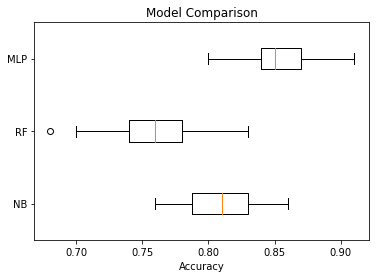

In [52]:
# 3. Visualise boxplot

def read_results(csvfile):
    results = []

    with open(csvfile, "r") as csv_file:
        next(csv_file)
        for line in csv_file:
            temp = line.strip()
            temp = temp.split(",")
            model = temp[1]
            results.append(float(temp[-2]))
        
    return model, results

mod1, res1 = read_results("NB_results")
mod2, res2 = read_results("RF_results")
mod3, res3 = read_results("MLP_results")
# res4 = all_scores

plt.boxplot([res1, res2, res3], vert = 0, labels=["NB", "RF", "MLP"])
plt.title("Model Comparison")
plt.xlabel("Accuracy")
plt.savefig("boxplot.png", dpi=300)
plt.show()

In [64]:
# 4. Find best parameters across 10-folds and predict for validation data

parameters_mlp = {'estimator__activation':['identity', 'logistic', 'tanh', 'relu'],
              'estimator__solver': ['lbfgs', 'sgd', 'adam'], 
              'estimator__max_iter': [100, 250, 500, 1000, 1500, 2000, 2500, 3000], 
              'estimator__hidden_layer_sizes':np.linspace(10, 200, 20, dtype=int)
             }

mlp = MLPClassifier()

folds = StratifiedKFold(n_splits=10, shuffle=True)

onevsrest_mlp = OneVsRestClassifier(mlp)
        
model = RandomizedSearchCV(estimator=onevsrest_mlp, param_distributions=parameters_mlp, cv=folds, n_jobs=-1)
model.fit(X, Y)

C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=OneVsRestClassifier(estimator=MLPClassifier(activation='relu',
                                                                         alpha=0.0001,
                                                                         batch_size='auto',
                                                                         beta_1=0.9,
                                                                         beta_2=0.999,
                                                                         early_stopping=False,
                                                                         epsilon=1e-08,
                                                                         hidden_layer_sizes=(100,),
                                                                         learning_rate='constant',
                                                      

In [67]:
# Load validation set and take features

temp_list = []

with open("Validation_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_test = pd.DataFrame(temp_list[1:], columns=columns_temp)
test_set = df_test.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
test_set = test_set.transpose()

for i, val in enumerate(p_val):
    if val >= threshold and i not in important_genes:
        test_set = test_set.drop([i], axis=1)

In [91]:
patient_ids = test_set.index.values

In [80]:
predictions = model.predict(test_set)

In [124]:
output_preds = []

for i, pred in enumerate(predictions):
    if pred == 1:
        output_preds.append([patient_ids[i],"HER2+"])
    if pred == 2:
        output_preds.append([patient_ids[i],"HR+"])
    if pred == 3:
        output_preds.append([patient_ids[i],"Triple Neg"])

file1 = open("predictions.txt","w") 
        
file1.write("\"Sample\" \t \"Subgroup\"\n")
for i, prediction in enumerate(predictions):
    file1.write("\"{0}\" \t \"{1}\"\n".format(output_preds[i][0], output_preds[i][1]))

In [125]:
print(output_preds)

[['Array.1', 'HR+'], ['Array.61', 'HER2+'], ['Array.70', 'Triple Neg'], ['Array.14', 'HER2+'], ['Array.91', 'Triple Neg'], ['Array.58', 'Triple Neg'], ['Array.140', 'HER2+'], ['Array.20', 'HR+'], ['Array.133', 'Triple Neg'], ['Array.77', 'HER2+'], ['Array.131', 'HER2+'], ['Array.84', 'HR+'], ['Array.44', 'Triple Neg'], ['Array.41', 'HER2+'], ['Array.29', 'HR+'], ['Array.150', 'HER2+'], ['Array.151', 'HR+'], ['Array.132', 'HR+'], ['Array.32', 'HR+'], ['Array.11', 'HR+'], ['Array.156', 'HR+'], ['Array.80', 'HER2+'], ['Array.9', 'HER2+'], ['Array.3', 'HR+'], ['Array.136', 'HR+'], ['Array.46', 'HER2+'], ['Array.109', 'HER2+'], ['Array.103', 'Triple Neg'], ['Array.97', 'HR+'], ['Array.40', 'HR+'], ['Array.147', 'HER2+'], ['Array.161', 'Triple Neg'], ['Array.127', 'Triple Neg'], ['Array.119', 'Triple Neg'], ['Array.157', 'HER2+'], ['Array.54', 'HR+'], ['Array.115', 'HR+'], ['Array.121', 'HER2+'], ['Array.122', 'HER2+'], ['Array.158', 'Triple Neg'], ['Array.87', 'HER2+'], ['Array.28', 'HER2+'

In [98]:
np.savetxt("predictions.txt", output_frame.values, fmt="%s")

In [73]:
import pickle

pkl_filename = "cats_12_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)